In [40]:
import os
import re
import glob
import mne
import numpy as np
import matplotlib.pyplot as plt

In [41]:
%matplotlib inline
data_path = "/Users/jananjahed/Desktop/Bachelor's project/ds005873"

all_edf_files = glob.glob(os.path.join(data_path, "**", "*_eeg.edf"), recursive=True)
print(f"Found {len(all_edf_files)} EDF files total.")

subjects_dict = {}

Found 2853 EDF files total.


In [42]:
def get_sub_id(filepath):
    """
    Extracts the subject ID
    Adjust the regex
    """
    match = re.search(r"(sub-\d+)", filepath)
    return match.group(1) if match else None

for f in all_edf_files:
    sub_id = get_sub_id(f)
    if sub_id is None:
        continue
    if sub_id not in subjects_dict:
        subjects_dict[sub_id] = []
    subjects_dict[sub_id].append(f)

all_subject_ids = sorted(subjects_dict.keys())
print(f"Found {len(all_subject_ids)} distinct subject IDs:", all_subject_ids)

five_subs = all_subject_ids[:10]
print("We will process these subject ID:", five_subs)

edf_files_5subs = []
for sid in five_subs:
    edf_files_5subs.extend(subjects_dict[sid])

print(f"Total EDF files for these subjects: {len(edf_files_5subs)}")

output_dir = os.path.join(data_path, "eeg_figures")
os.makedirs(output_dir, exist_ok=True)

evoked_list = []
psd_list = []
psd_freqs = None

example_saved = False
first_subject_id = None

Found 125 distinct subject IDs: ['sub-001', 'sub-002', 'sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-007', 'sub-008', 'sub-009', 'sub-010', 'sub-011', 'sub-012', 'sub-013', 'sub-014', 'sub-015', 'sub-016', 'sub-017', 'sub-018', 'sub-019', 'sub-020', 'sub-021', 'sub-022', 'sub-023', 'sub-024', 'sub-025', 'sub-026', 'sub-027', 'sub-028', 'sub-029', 'sub-030', 'sub-031', 'sub-032', 'sub-033', 'sub-034', 'sub-035', 'sub-036', 'sub-037', 'sub-038', 'sub-039', 'sub-040', 'sub-041', 'sub-042', 'sub-043', 'sub-044', 'sub-045', 'sub-046', 'sub-047', 'sub-048', 'sub-049', 'sub-050', 'sub-051', 'sub-052', 'sub-053', 'sub-054', 'sub-055', 'sub-056', 'sub-057', 'sub-058', 'sub-059', 'sub-060', 'sub-061', 'sub-062', 'sub-063', 'sub-064', 'sub-065', 'sub-066', 'sub-067', 'sub-068', 'sub-069', 'sub-070', 'sub-071', 'sub-072', 'sub-073', 'sub-074', 'sub-075', 'sub-076', 'sub-077', 'sub-078', 'sub-079', 'sub-080', 'sub-081', 'sub-082', 'sub-083', 'sub-084', 'sub-085', 'sub-086', 'sub-087', 'sub-088',


Visualizing raw data from: /Users/jananjahed/Desktop/Bachelor's project/ds005873/sub-001/ses-01/eeg/sub-001_ses-01_task-szMonitoring_run-04_eeg.edf
Extracting EDF parameters from /Users/jananjahed/Desktop/Bachelor's project/ds005873/sub-001/ses-01/eeg/sub-001_ses-01_task-szMonitoring_run-04_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5429503  =      0.000 ... 21208.996 secs...

Raw data info:
<Info | 8 non-empty values
 bads: []
 ch_names: BTEleft SD, CROSStop SD
 chs: 2 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 nchan: 2
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: x, sex: 2, last_name: x>
>


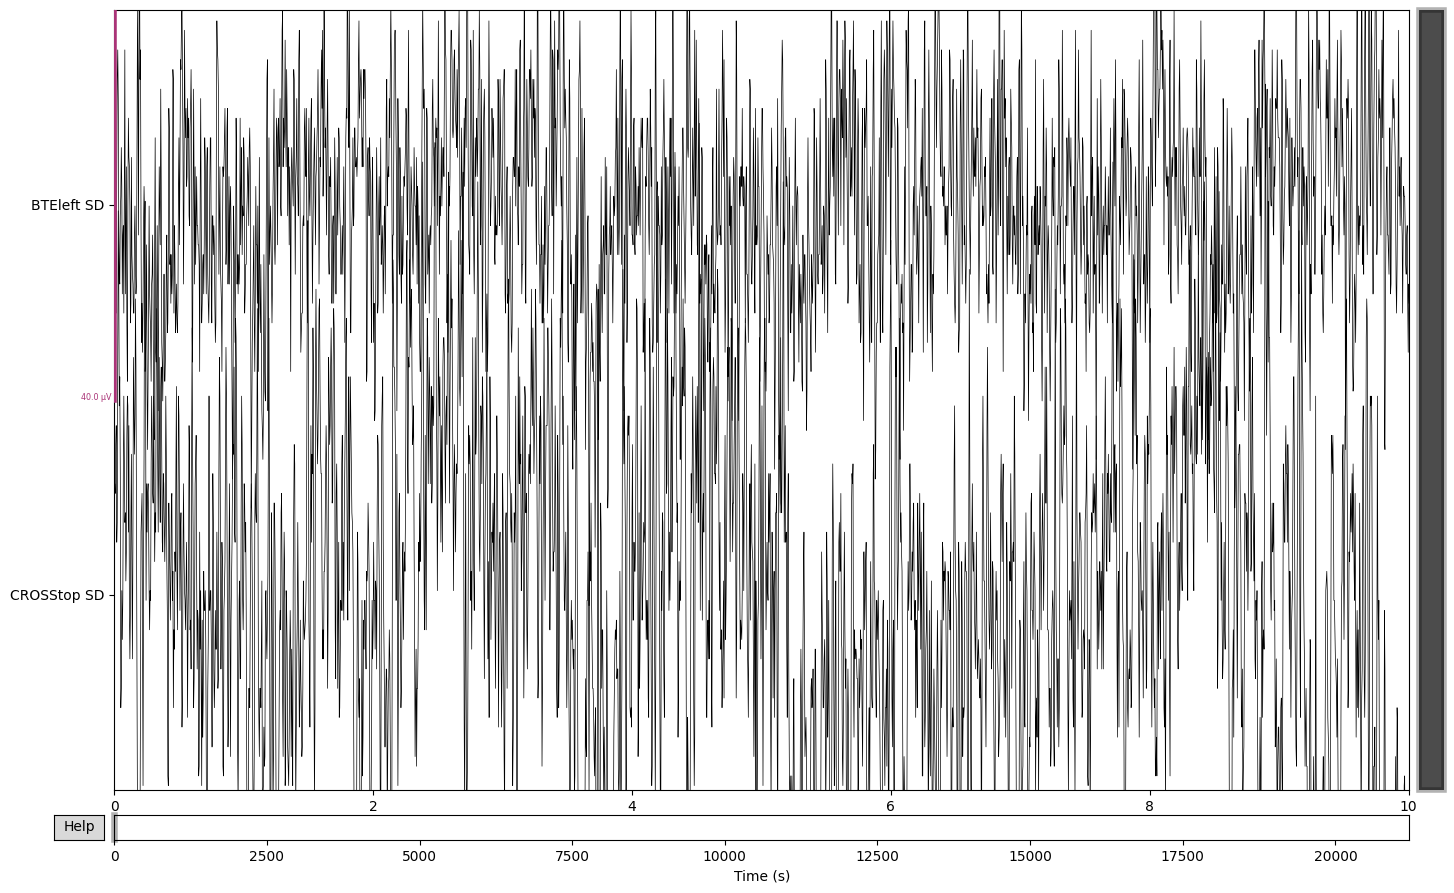

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


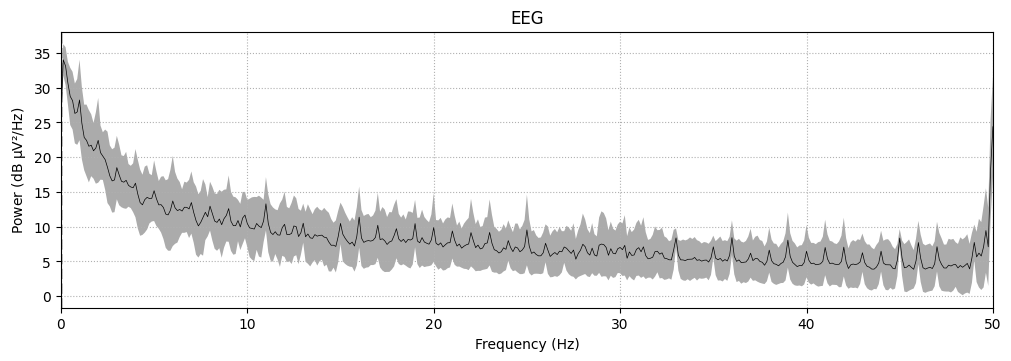

In [43]:

if edf_files_5subs:
    example_edf = edf_files_5subs[0]
    print("\nVisualizing raw data from:", example_edf)

    raw = mne.io.read_raw_edf(example_edf, preload=True)
    
    print("\nRaw data info:")
    print(raw.info)

    raw.plot(title='Raw EEG Data', show=True, block=True)

    raw.plot_psd(fmax=50, average=True)
else:
    print("No EDF files available for raw visualization.")

In [44]:
# function to process a single EDF file and save the plots to the directory
def process_one_file(edf_file):
    """Processes one EDF file:
       - Conditional rename
       - Montage
       - Filter (1-40 Hz)
       - ICA with EOG check (wrapped in try/except)
       - Synthetic events, epoching, evoked
       - PSD (Welch)
       Returns: (raw, epochs, evoked, avg_psd, freqs)
    """
    print(f"\n--- Processing {edf_file} ---")
    raw = mne.io.read_raw_edf(edf_file, preload=True)
    
    #RENAMING THE CHANNELS
    rename_dict = {}
    if "BTEleft SD" in raw.ch_names:
        rename_dict["BTEleft SD"] = "T7"
    if "CROSStop SD" in raw.ch_names:
        rename_dict["CROSStop SD"] = "T8"
    if rename_dict:
        raw.rename_channels(rename_dict)
    
    if "T7" in raw.ch_names:
        raw.set_channel_types({"T7": "eeg"})
    if "T8" in raw.ch_names:
        raw.set_channel_types({"T8": "eeg"})
    
    #MONTAGE
    montage = mne.channels.make_standard_montage("standard_1020")
    raw.set_montage(montage, on_missing="ignore")
    
    raw.filter(l_freq=1, h_freq=40)
    
    # ICA
    from mne.preprocessing import ICA
    n_eeg = len(raw.pick_types(eeg=True).ch_names)
    ica = ICA(n_components=min(n_eeg, 20), random_state=97, max_iter='auto')
    ica.fit(raw.pick_types(eeg=True))
    try:
        eog_inds, eog_scores = ica.find_bads_eog(raw, threshold=3.0)
        if eog_inds:
            ica.exclude = eog_inds
    except Exception:
        print("No EOG channel(s) found or other EOG detection error. Skipping EOG-based exclusion.")
    ica.apply(raw)
    
    # SYNTHETIC EVENTS
    sfreq = raw.info['sfreq']
    n_samples = raw.n_times
    onsets = np.arange(0, n_samples, int(10 * sfreq))
    events = np.column_stack((onsets, np.zeros(len(onsets), int), np.ones(len(onsets), int)))
    
    # EPOCH
    event_id = {"synthetic": 1}
    epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-0.2, tmax=0.8, baseline=(None, 0), preload=True)
    evoked = epochs.average() if len(epochs) > 0 else None
    
    # PSD 
    if n_eeg > 0:
        psd = raw.compute_psd(method='welch', picks='eeg', fmin=1, fmax=50, n_fft=2048)
        psd_data = psd.get_data()
        freqs = psd.freqs 
        avg_psd = np.mean(psd_data, axis=0)
    else:
        avg_psd, freqs = None, None
    
    return raw, epochs, evoked, avg_psd, freqs

In [45]:
# main Loop for all 5 subjects
for i, edf_file in enumerate(edf_files_5subs):
    try:
        raw, epochs, evoked, avg_psd, freqs = process_one_file(edf_file)
        
        if evoked is not None:
            evoked_list.append(evoked)
        
        if avg_psd is not None and freqs is not None:
            psd_list.append(avg_psd)
            if psd_freqs is None:
                psd_freqs = freqs
        
        if not example_saved:
            subject_id = get_sub_id(edf_file)
            if subject_id and first_subject_id is None:
                first_subject_id = subject_id
            
            if first_subject_id == subject_id:
                fig_sensors = raw.plot_sensors(show_names=True, show=False)
                fig_sensors.savefig(os.path.join(output_dir, f"{subject_id}_sensors.png"))
                plt.close(fig_sensors)
                
                fig_psd = raw.plot_psd(fmax=50, show=False)
                fig_psd.savefig(os.path.join(output_dir, f"{subject_id}_psd.png"))
                plt.close(fig_psd)
                
                fig_raw = raw.plot(duration=30, n_channels=len(raw.ch_names), scalings='auto', show=False)
                fig_raw.savefig(os.path.join(output_dir, f"{subject_id}_raw_overview.png"))
                plt.close(fig_raw)
                
                fig_epochs = epochs.plot(show=False)
                fig_epochs.savefig(os.path.join(output_dir, f"{subject_id}_epochs_overview.png"))
                plt.close(fig_epochs)
                
                if evoked is not None:
                    fig_evoked = evoked.plot(spatial_colors=True, time_unit='s', show=False)
                    fig_evoked.savefig(os.path.join(output_dir, f"{subject_id}_evoked.png"))
                    plt.close(fig_evoked)
                    
                    times = [0.1, 0.2, 0.3, 0.4]
                    fig_topomap = evoked.plot_topomap(times=times, ch_type='eeg', time_unit='s', show=False)
                    if isinstance(fig_topomap, list):
                        for j, fg in enumerate(fig_topomap):
                            fg.savefig(os.path.join(output_dir, f"{subject_id}_topomap_{j}.png"))
                            plt.close(fg)
                    else:
                        fig_topomap.savefig(os.path.join(output_dir, f"{subject_id}_topomap.png"))
                        plt.close(fig_topomap)
                
                print(f"Saved example subject's plots for {subject_id} in {output_dir}")
                example_saved = True

    except Exception as e:
        print(f"Error processing {edf_file}: {e}")


--- Processing /Users/jananjahed/Desktop/Bachelor's project/ds005873/sub-001/ses-01/eeg/sub-001_ses-01_task-szMonitoring_run-04_eeg.edf ---
Extracting EDF parameters from /Users/jananjahed/Desktop/Bachelor's project/ds005873/sub-001/ses-01/eeg/sub-001_ses-01_task-szMonitoring_run-04_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5429503  =      0.000 ... 21208.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

NO

Identifying common channels ...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pi

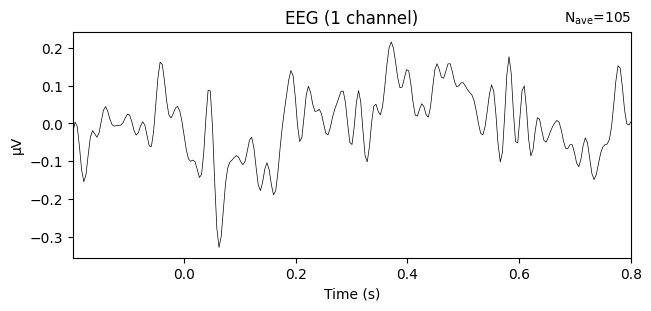

Grand average ERP plot saved to /Users/jananjahed/Desktop/Bachelor's project/ds005873/eeg_figures/grand_average_evoked_10subjects.png


In [46]:
#Grand Average ERP plot
if evoked_list:
    grand_average = mne.grand_average(evoked_list)
    fig_grand = grand_average.plot(spatial_colors=True, time_unit='s', show=True)
    ga_erp_path = os.path.join(output_dir, "grand_average_evoked_10subjects.png")
    fig_grand.savefig(ga_erp_path)
    plt.close(fig_grand)
    print(f"Grand average ERP plot saved to {ga_erp_path}")
else:
    print("No evoked data available for grand average ERP.")

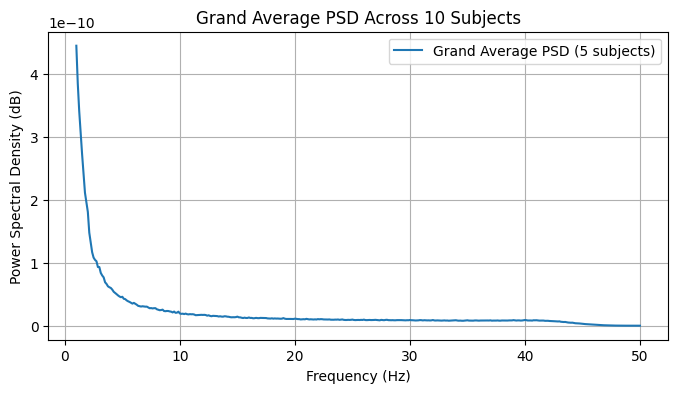

Grand average PSD plot saved to /Users/jananjahed/Desktop/Bachelor's project/ds005873/eeg_figures/grand_average_psd_10subjects.png
Done! Processed exactly 10 subjects (all runs/sessions). Only one subject's plots saved, plus grand averages.


In [47]:
# Grand Average PSD plot
if psd_list and psd_freqs is not None:
    grand_psd = np.mean(np.vstack(psd_list), axis=0)
    plt.figure(figsize=(8,4))
    plt.plot(psd_freqs, grand_psd, label="Grand Average PSD (5 subjects)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density (dB)")
    plt.title("Grand Average PSD Across 10 Subjects")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    ga_psd_path = os.path.join(output_dir, "grand_average_psd_10subjects.png")
    plt.savefig(ga_psd_path)
    plt.close()
    print(f"Grand average PSD plot saved to {ga_psd_path}")
else:
    print("No PSD data available for grand average PSD.")

print("Done! Processed exactly 10 subjects (all runs/sessions). Only one subject's plots saved, plus grand averages.")